# Patterns Mining & Association Rules, is clustering improving?
Mining frequent patterns and association rules over the [House prices dataset (Kaggle)](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) <br> 



### 0. Imports

In [1]:
#data processing
import pandas as pd
import numpy as np
import scipy as sp

#statistics
from scipy import stats
import statsmodels.api as sm


#data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


#Machine learning library
import sklearn

#Patterns Mining
from efficient_apriori import apriori

import warnings
warnings.filterwarnings("ignore")
import utils
import matplotlib.pyplot as plt
import seaborn as sns


##### Loading the CSV dataset

In [2]:
dataset_path = "../datasets/HousePrices.csv"
dtf = pd.read_csv(dataset_path,index_col='Id')
dtf

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


##### Defining numeric and categorical columns

In [3]:
numeric_columns = dtf.dtypes[(dtf.dtypes=="float64") | (dtf.dtypes=="int64")].index.tolist()
very_numerical = [nc for nc in numeric_columns if dtf[nc].nunique()>20]
categorical_columns = [c for c in dtf.columns if c not in numeric_columns]
ordinals = list(set(numeric_columns) - set(very_numerical))

##### Filling Null Values with the column's mean

In [4]:
na_columns = dtf[very_numerical].isna().sum()
na_columns = na_columns[na_columns>0]
for nc in na_columns.index:
    dtf[nc].fillna(dtf[nc].mean(),inplace=True)

##### Dropping and filling NA values for categorical columns:

1. drop if at least 70% are NA:

In [5]:
nul_cols = dtf[categorical_columns].isna().sum()/len(dtf)
drop_us = nul_cols[nul_cols>0.7]

In [6]:
dtf=dtf.drop(drop_us.index,axis=1)
categorical_columns = list(set(categorical_columns)-set(drop_us.index))

2. Fill with a new 'na' category:

In [7]:
dtf[categorical_columns]= dtf[categorical_columns].fillna('na')

#### one hot encoding/lable encoding Categorical data for clustreing

In [8]:

from sklearn.cluster import SpectralClustering,KMeans
import utils
dtf_encoded = utils.label_encoding(dtf, categorical_columns)

#### Run clustering

#### Find best k

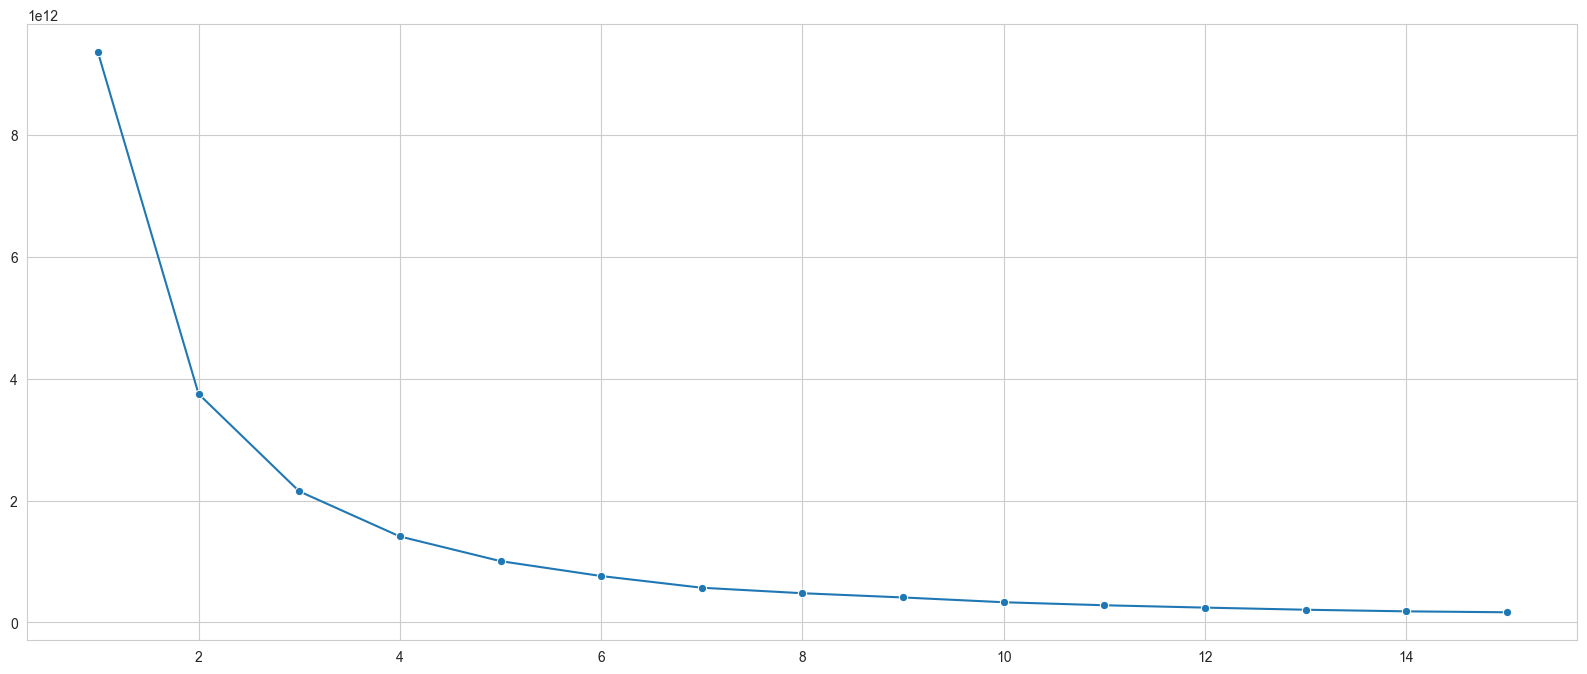

In [9]:
utils.opt_kmeans(dtf_encoded,15)

###

In [10]:
clusters = utils.run_k_means(6,dtf_encoded,dtf)
[len(a) for a in clusters.values()]

[499, 510, 136, 261, 46, 8]

##### removing small clusters

In [11]:
labels2remove = []
for label,cdf in clusters.items():
    #removing clusters under 2% in size
    if len(cdf) < len(dtf)/50:
        print(len(cdf))
        labels2remove.append(label)
for label in labels2remove:
    del clusters[label]
len(clusters)


8


5

### 2. Using Apriori on a each cluster:

### Preprocessing clusters for apriori

In [12]:
clusters[list(clusters.keys())[0]][:1]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
2,20,3,80.0,9600,1,3,3,0,2,0,...,0,0,0,0,0,5,2007,8,4,181500


In [13]:
for label,cdf in clusters.items():
    clusters[label] = utils.preprocess_4_apriori(cdf,very_numerical)
clusters[list(clusters.keys())[0]]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
2,20,3,high,medium,1,3,3,0,2,0,...,very low,0,very low,0,very low,5,2007,8,4,high
6,50,3,very high,very high,1,0,3,0,4,0,...,very low,320,very low,0,very low,10,2009,8,4,very low
13,20,3,medium,very high,1,1,3,0,4,0,...,very low,0,medium,0,very low,9,2008,8,4,very low
15,20,3,medium,high,1,0,3,0,0,0,...,medium,0,very low,0,very low,5,2008,8,4,low
17,20,3,medium,high,1,0,3,0,1,0,...,very low,0,very low,0,very low,3,2010,8,4,very low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,180,4,very low,very low,1,3,3,0,4,0,...,very low,0,very low,0,very low,5,2006,8,4,very low
1455,20,1,low,low,1,3,3,0,4,0,...,very low,0,very low,0,very low,10,2009,8,4,very high
1456,60,3,low,low,1,3,3,0,4,0,...,very low,0,very low,0,very low,8,2007,8,4,high


In [14]:
clusters[list(clusters.keys())[0]][:1]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
2,20,3,high,medium,1,3,3,0,2,0,...,very low,0,very low,0,very low,5,2007,8,4,high


In [15]:
#might need to select only several columns for running effiency
patitioned_total_rules = set()

for label,cdf in clusters.items():
    good_columns = ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'OverallQual', 'OverallCond', 'BldgType', 'LotArea', 'GrLivArea', 'FullBath', 'BedroomAbvGr', 'LotFrontage', 'TotalBsmtSF', 'SalePrice']
    gdf = cdf[good_columns]
    transactions = utils.convert_ds_to_transactions(gdf)
    itemsets, rules = apriori(transactions, min_support=0.5, min_confidence=0.8,output_transaction_ids=False)
    print(len(patitioned_total_rules))
    patitioned_total_rules.update(rules)
len(patitioned_total_rules)

0
1
3
14
18


19

### do apriori on the initial dataset for comparison

In [16]:
good_columns = ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'OverallQual', 'OverallCond', 'BldgType', 'LotArea', 'GrLivArea', 'FullBath', 'BedroomAbvGr', 'LotFrontage', 'TotalBsmtSF', 'SalePrice']
gdf = dtf[good_columns]
transactions = utils.convert_ds_to_transactions(gdf)
unpatitioned_total_itemsets, unpatitioned_total_rules = apriori(transactions, min_support=0.5, min_confidence=0.8,output_transaction_ids=False)

## 2. Analyzing the rules:
We need a measures of interestingness to evaluate our results.

We first use the Lift measurement taught in class.
on top of that we use the Conviction and Leverage measurements.
formulas and meaning of those can be seen in the report file.

### Lift comparison

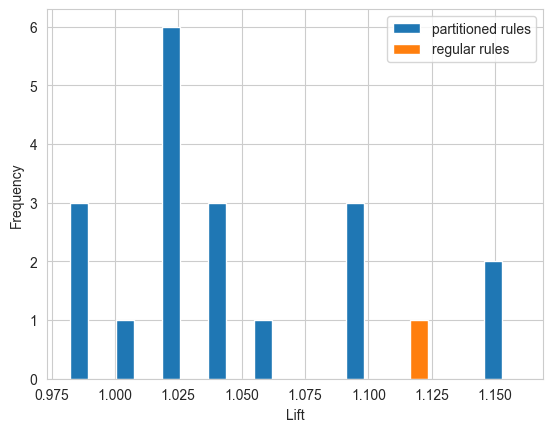

In [17]:
partitioned_lift_arr = [rule.lift for rule in patitioned_total_rules]
unpartitioned_lift_arr = [rule.lift for rule in unpatitioned_total_rules]
plt.hist([partitioned_lift_arr,unpartitioned_lift_arr])
plt.legend(['partitioned rules','regular rules'])
plt.xlabel('Lift')
plt.ylabel('Frequency')

plt.show()


### Conviction comparison

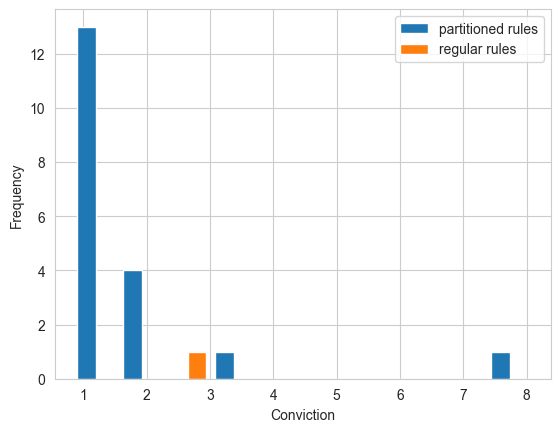

In [18]:
#creating conviction graph for both the partitioned rules and the unpartitioned rules
partitioned_conviction_arr = [rule.conviction for rule in patitioned_total_rules]
unpartitioned_conviction_arr = [rule.conviction for rule in unpatitioned_total_rules]
plt.hist([partitioned_conviction_arr,unpartitioned_conviction_arr])
plt.legend(['partitioned rules','regular rules'])
plt.xlabel('Conviction')
plt.ylabel('Frequency')

plt.show()

### Confidence comparison


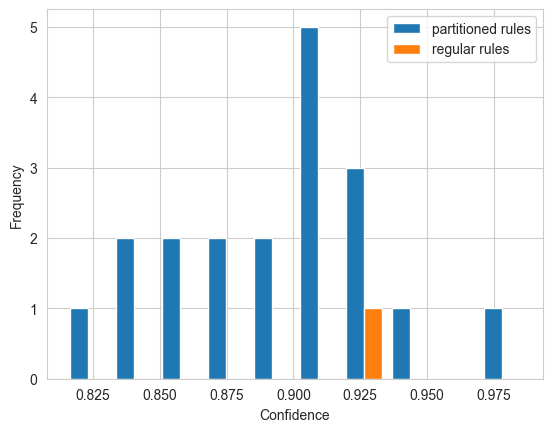

In [19]:
partitioned_conf_arr = [rule.confidence for rule in patitioned_total_rules]
unpartitioned_conf_arr = [rule.confidence for rule in unpatitioned_total_rules]
plt.hist([partitioned_conf_arr,unpartitioned_conf_arr])
plt.legend(['partitioned rules','regular rules'])
plt.xlabel('Confidence')
plt.ylabel('Frequency')

plt.show()